## Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

In [2]:
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)

## Data Reading

In [3]:
train_df = pd.read_csv('UNSW_NB15_training-set.csv')

In [4]:
train_df

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,dwin,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.121478,tcp,-,FIN,6,4,258,172,74.087490,252,254,1.415894e+04,8495.365234,0,0,24.295600,8.375000,30.177547,11.830604,255,621772692,2202533631,255,0.000000,0.000000,0.000000,43,43,0,0,1,0,1,1,1,1,0,0,0,1,1,0,Normal,0
1,2,0.649902,tcp,-,FIN,14,38,734,42014,78.473372,62,252,8.395112e+03,503571.312500,2,17,49.915000,15.432865,61.426934,1387.778330,255,1417884146,3077387971,255,0.000000,0.000000,0.000000,52,1106,0,0,43,1,1,1,1,2,0,0,0,1,6,0,Normal,0
2,3,1.623129,tcp,-,FIN,8,16,364,13186,14.170161,62,252,1.572272e+03,60929.230470,1,6,231.875571,102.737203,17179.586860,11420.926230,255,2116150707,2963114973,255,0.111897,0.061458,0.050439,46,824,0,0,7,1,2,1,1,3,0,0,0,2,6,0,Normal,0
3,4,1.681642,tcp,ftp,FIN,12,12,628,770,13.677108,62,252,2.740179e+03,3358.622070,1,3,152.876547,90.235726,259.080172,4991.784669,255,1107119177,1047442890,255,0.000000,0.000000,0.000000,52,64,0,0,1,1,2,1,1,3,1,1,0,2,1,0,Normal,0
4,5,0.449454,tcp,-,FIN,10,6,534,268,33.373826,254,252,8.561499e+03,3987.059814,2,1,47.750333,75.659602,2415.837634,115.807000,255,2436137549,1977154190,255,0.128381,0.071147,0.057234,53,45,0,0,43,1,2,2,1,40,0,0,0,2,39,0,Normal,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175336,175337,0.000009,udp,dns,INT,2,0,114,0,111111.107200,254,0,5.066666e+07,0.000000,0,0,0.009000,0.000000,0.000000,0.000000,0,0,0,0,0.000000,0.000000,0.000000,57,0,0,0,24,2,24,24,13,24,0,0,0,24,24,0,Generic,1
175337,175338,0.505762,tcp,-,FIN,10,8,620,354,33.612649,254,252,8.826286e+03,4903.492188,2,1,54.400111,66.980570,3721.068786,120.177727,255,3518776216,3453092386,255,0.099440,0.036895,0.062545,62,44,0,0,1,1,1,1,1,2,0,0,0,1,1,0,Shellcode,1
175338,175339,0.000009,udp,dns,INT,2,0,114,0,111111.107200,254,0,5.066666e+07,0.000000,0,0,0.009000,0.000000,0.000000,0.000000,0,0,0,0,0.000000,0.000000,0.000000,57,0,0,0,12,2,3,3,3,13,0,0,0,3,12,0,Generic,1
175339,175340,0.000009,udp,dns,INT,2,0,114,0,111111.107200,254,0,5.066666e+07,0.000000,0,0,0.009000,0.000000,0.000000,0.000000,0,0,0,0,0.000000,0.000000,0.000000,57,0,0,0,30,2,30,30,14,30,0,0,0,30,30,0,Generic,1


In [5]:
train_df.drop(['id', 'attack_cat'], axis = 1, inplace = True)

## Feature Encoding

### Code for Target Encoding with Smoothing

In [6]:
def target_smooth(df, target, categorical, smoothing, min_samples_leaf=1):
    mean_target = df[target].mean()
    agg = df.groupby(categorical)[target].agg(['mean', 'count'])
    smooth = (agg['count'] * agg['mean'] + smoothing * mean_target) / (agg['count'] + smoothing)
    return smooth  

In [7]:
def cross_validation_smooth(df, target, categorical, smoothing, n_splits=10):
    df[f'{categorical}_target_encoded'] = np.nan
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    for train_idx, val_idx in kf.split(df):
        train_fold, val_fold = df.iloc[train_idx], df.iloc[val_idx]
        smoothed_means = target_smooth(train_fold, target, categorical, smoothing=smoothing)
        df.loc[val_idx, f'{categorical}_target_encoded'] = df.loc[val_idx, categorical].map(smoothed_means)
        
    overall_mean_target = df[target].mean()
    df[f'{categorical}_target_encoded'].fillna(overall_mean_target, inplace=True)
    
    return df, smoothed_means, overall_mean_target 

### 1. Protocol

In [8]:
train_df, proto_stats, proto_overall_mean = cross_validation_smooth(train_df, 'label', 'proto', smoothing=1)

In [9]:
train_df.head()

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,dwin,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,label,proto_target_encoded
0,0.121478,tcp,-,FIN,6,4,258,172,74.087490,252,254,14158.942380,8495.365234,0,0,24.295600,8.375000,30.177547,11.830604,255,621772692,2202533631,255,0.000000,0.000000,0.000000,43,43,0,0,1,0,1,1,1,1,0,0,0,1,1,0,0,0.510473
1,0.649902,tcp,-,FIN,14,38,734,42014,78.473372,62,252,8395.112305,503571.312500,2,17,49.915000,15.432865,61.426934,1387.778330,255,1417884146,3077387971,255,0.000000,0.000000,0.000000,52,1106,0,0,43,1,1,1,1,2,0,0,0,1,6,0,0,0.510508
2,1.623129,tcp,-,FIN,8,16,364,13186,14.170161,62,252,1572.271851,60929.230470,1,6,231.875571,102.737203,17179.586860,11420.926230,255,2116150707,2963114973,255,0.111897,0.061458,0.050439,46,824,0,0,7,1,2,1,1,3,0,0,0,2,6,0,0,0.511369
3,1.681642,tcp,ftp,FIN,12,12,628,770,13.677108,62,252,2740.178955,3358.622070,1,3,152.876547,90.235726,259.080172,4991.784669,255,1107119177,1047442890,255,0.000000,0.000000,0.000000,52,64,0,0,1,1,2,1,1,3,1,1,0,2,1,0,0,0.510828
4,0.449454,tcp,-,FIN,10,6,534,268,33.373826,254,252,8561.499023,3987.059814,2,1,47.750333,75.659602,2415.837634,115.807000,255,2436137549,1977154190,255,0.128381,0.071147,0.057234,53,45,0,0,43,1,2,2,1,40,0,0,0,2,39,0,0,0.509765


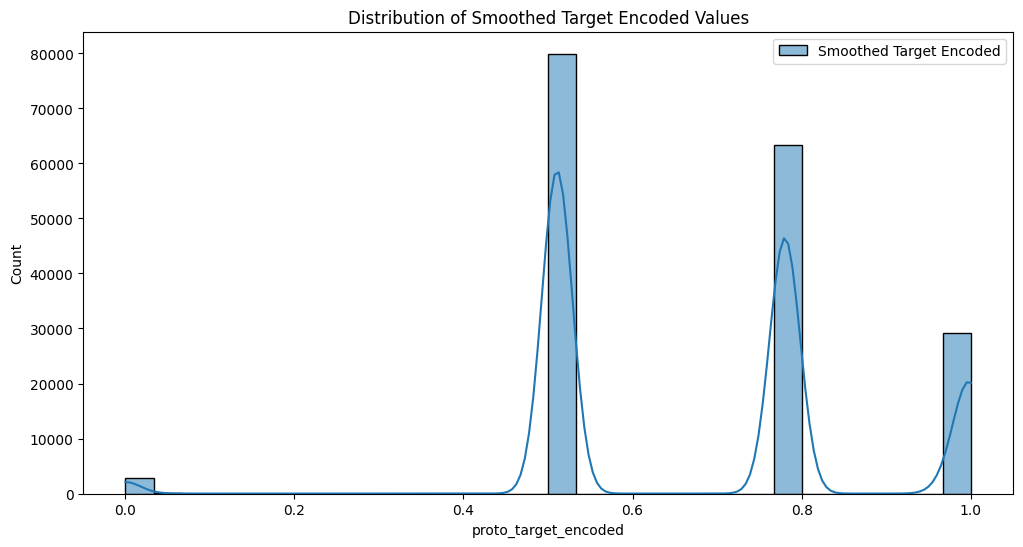

In [10]:
#plotting the smoothed means
plt.figure(figsize=(12, 6))
sns.histplot(train_df['proto_target_encoded'], kde=True, bins=30, label='Smoothed Target Encoded')
plt.legend()
plt.title('Distribution of Smoothed Target Encoded Values')
plt.show()

In [11]:
train_df.drop('proto', axis = 1, inplace = True)

### 2. Service

In [12]:
train_df, service_stats, service_overall_mean = cross_validation_smooth(train_df, 'label', 'service', smoothing=10)

In [13]:
train_df

,dur,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,dwin,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,label,proto_target_encoded,service_target_encoded
0,0.121478,-,FIN,6,4,258,172,74.087490,252,254,1.415894e+04,8495.365234,0,0,24.295600,8.375000,30.177547,11.830604,255,621772692,2202533631,255,0.000000,0.000000,0.000000,43,43,0,0,1,0,1,1,1,1,0,0,0,1,1,0,0,0.510473,0.612241
1,0.649902,-,FIN,14,38,734,42014,78.473372,62,252,8.395112e+03,503571.312500,2,17,49.915000,15.432865,61.426934,1387.778330,255,1417884146,3077387971,255,0.000000,0.000000,0.000000,52,1106,0,0,43,1,1,1,1,2,0,0,0,1,6,0,0,0.510508,0.612708
2,1.623129,-,FIN,8,16,364,13186,14.170161,62,252,1.572272e+03,60929.230470,1,6,231.875571,102.737203,17179.586860,11420.926230,255,2116150707,2963114973,255,0.111897,0.061458,0.050439,46,824,0,0,7,1,2,1,1,3,0,0,0,2,6,0,0,0.511369,0.612793
3,1.681642,ftp,FIN,12,12,628,770,13.677108,62,252,2.740179e+03,3358.622070,1,3,152.876547,90.235726,259.080172,4991.784669,255,1107119177,1047442890,255,0.000000,0.000000,0.000000,52,64,0,0,1,1,2,1,1,3,1,1,0,2,1,0,0,0.510828,0.642405
4,0.449454,-,FIN,10,6,534,268,33.373826,254,252,8.561499e+03,3987.059814,2,1,47.750333,75.659602,2415.837634,115.807000,255,2436137549,1977154190,255,0.128381,0.071147,0.057234,53,45,0,0,43,1,2,2,1,40,0,0,0,2,39,0,0,0.509765,0.612396
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175336,0.000009,dns,INT,2,0,114,0,111111.107200,254,0,5.066666e+07,0.000000,0,0,0.009000,0.000000,0.000000,0.000000,0,0,0,0,0.000000,0.000000,0.000000,57,0,0,0,24,2,24,24,13,24,0,0,0,24,24,0,1,0.779252,0.840604
175337,0.505762,-,FIN,10,8,620,354,33.612649,254,252,8.826286e+03,4903.492188,2,1,54.400111,66.980570,3721.068786,120.177727,255,3518776216,3453092386,255,0.099440,0.036895,0.062545,62,44,0,0,1,1,1,1,1,2,0,0,0,1,1,0,1,0.509765,0.612396
175338,0.000009,dns,INT,2,0,114,0,111111.107200,254,0,5.066666e+07,0.000000,0,0,0.009000,0.000000,0.000000,0.000000,0,0,0,0,0.000000,0.000000,0.000000,57,0,0,0,12,2,3,3,3,13,0,0,0,3,12,0,1,0.780431,0.842292
175339,0.000009,dns,INT,2,0,114,0,111111.107200,254,0,5.066666e+07,0.000000,0,0,0.009000,0.000000,0.000000,0.000000,0,0,0,0,0.000000,0.000000,0.000000,57,0,0,0,30,2,30,30,14,30,0,0,0,30,30,0,1,0.780200,0.841158


In [14]:
train_df.drop('service', axis = 1, inplace = True)

### 3. State

In [15]:
train_df, state_stats, state_overall_mean = cross_validation_smooth(train_df, 'label', 'state', smoothing=20)

In [16]:
train_df

,dur,state,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,dwin,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,label,proto_target_encoded,service_target_encoded,state_target_encoded
0,0.121478,FIN,6,4,258,172,74.087490,252,254,1.415894e+04,8495.365234,0,0,24.295600,8.375000,30.177547,11.830604,255,621772692,2202533631,255,0.000000,0.000000,0.000000,43,43,0,0,1,0,1,1,1,1,0,0,0,1,1,0,0,0.510473,0.612241,0.522258
1,0.649902,FIN,14,38,734,42014,78.473372,62,252,8.395112e+03,503571.312500,2,17,49.915000,15.432865,61.426934,1387.778330,255,1417884146,3077387971,255,0.000000,0.000000,0.000000,52,1106,0,0,43,1,1,1,1,2,0,0,0,1,6,0,0,0.510508,0.612708,0.522127
2,1.623129,FIN,8,16,364,13186,14.170161,62,252,1.572272e+03,60929.230470,1,6,231.875571,102.737203,17179.586860,11420.926230,255,2116150707,2963114973,255,0.111897,0.061458,0.050439,46,824,0,0,7,1,2,1,1,3,0,0,0,2,6,0,0,0.511369,0.612793,0.523090
3,1.681642,FIN,12,12,628,770,13.677108,62,252,2.740179e+03,3358.622070,1,3,152.876547,90.235726,259.080172,4991.784669,255,1107119177,1047442890,255,0.000000,0.000000,0.000000,52,64,0,0,1,1,2,1,1,3,1,1,0,2,1,0,0,0.510828,0.642405,0.522420
4,0.449454,FIN,10,6,534,268,33.373826,254,252,8.561499e+03,3987.059814,2,1,47.750333,75.659602,2415.837634,115.807000,255,2436137549,1977154190,255,0.128381,0.071147,0.057234,53,45,0,0,43,1,2,2,1,40,0,0,0,2,39,0,0,0.509765,0.612396,0.521431
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175336,0.000009,INT,2,0,114,0,111111.107200,254,0,5.066666e+07,0.000000,0,0,0.009000,0.000000,0.000000,0.000000,0,0,0,0,0.000000,0.000000,0.000000,57,0,0,0,24,2,24,24,13,24,0,0,0,24,24,0,1,0.779252,0.840604,0.930208
175337,0.505762,FIN,10,8,620,354,33.612649,254,252,8.826286e+03,4903.492188,2,1,54.400111,66.980570,3721.068786,120.177727,255,3518776216,3453092386,255,0.099440,0.036895,0.062545,62,44,0,0,1,1,1,1,1,2,0,0,0,1,1,0,1,0.509765,0.612396,0.521431
175338,0.000009,INT,2,0,114,0,111111.107200,254,0,5.066666e+07,0.000000,0,0,0.009000,0.000000,0.000000,0.000000,0,0,0,0,0.000000,0.000000,0.000000,57,0,0,0,12,2,3,3,3,13,0,0,0,3,12,0,1,0.780431,0.842292,0.930371
175339,0.000009,INT,2,0,114,0,111111.107200,254,0,5.066666e+07,0.000000,0,0,0.009000,0.000000,0.000000,0.000000,0,0,0,0,0.000000,0.000000,0.000000,57,0,0,0,30,2,30,30,14,30,0,0,0,30,30,0,1,0.780200,0.841158,0.930614


In [17]:
train_df.drop('state', axis = 1, inplace = True)

## Saving the file to Encode the Test Data

In [119]:
with open('encoding_stats.pkl', 'wb') as f:
    pickle.dump({
        'proto': (proto_stats, proto_overall_mean),
        'service': (service_stats, service_overall_mean),
        'state': (state_stats, state_overall_mean)
    }, f)

## Feature Scaling

#### Identifying Discrete and Continuous Columns

In [18]:
#setting the threshold as 10
threshold = 4

discrete_columns = [col for col in train_df.columns if train_df[col].nunique() <= threshold]
continuous_columns = [col for col in train_df.columns if train_df[col].nunique() > threshold]

In [20]:
discrete_columns

['is_ftp_login', 'ct_ftp_cmd', 'is_sm_ips_ports', 'label']

In [122]:
robust_scaler = RobustScaler()
robust_scaler

RobustScaler()

In [123]:
train_df[continuous_columns] = robust_scaler.fit_transform(train_df[continuous_columns])

In [124]:
with open('robust_scaler_model.pkl', 'wb') as f:
    pickle.dump(robust_scaler, f)

In [83]:
train_df.head()

,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,dwin,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,label,proto_target_encoded,service_target_encoded,state_target_encoded
0,0.179469,0.4,0.2,-0.131902,0.007260,-0.025220,-0.010417,0.892857,-0.009738,0.253129,0.000000,0.0,0.435473,0.163928,0.012007,0.102883,1.0,0.324406,1.150945,1.0,0.000000,0.000000,0.000000,-0.697674,-0.011236,0.0,0.0,-0.4,-1.0,-0.166667,0.00,0.0,-0.181818,0,0,0.0,-0.285714,-0.3,0,0,-0.995621,-0.002417,-0.002039
1,0.970450,1.2,3.6,0.233129,37.976407,-0.025185,-1.000000,0.884921,-0.009803,18.032918,0.666667,8.5,0.900023,0.302174,0.024441,12.068622,1.0,0.739772,1.608104,1.0,0.000000,0.000000,0.000000,-0.488372,11.932584,0.0,0.0,3.8,0.0,-0.166667,0.00,0.0,-0.090909,0,0,0.0,-0.285714,0.2,0,0,-0.995493,-0.000370,-0.002362
2,2.427244,0.6,1.4,-0.050613,11.816697,-0.025700,-1.000000,0.884921,-0.009880,2.136200,0.333333,3.0,4.199465,2.012246,6.835484,99.320499,1.0,1.104087,1.548390,1.0,1.708847,2.641310,1.296432,-0.627907,8.764045,0.0,0.0,0.2,0.0,0.000000,0.00,0.0,0.000000,0,0,0.0,-0.142857,0.2,0,0,-0.992300,0.000000,0.000000
3,2.514830,1.0,1.0,0.151840,0.549909,-0.025704,-1.000000,0.884921,-0.009867,0.068652,0.333333,1.5,2.766997,1.767374,0.103084,43.410362,1.0,0.577632,0.547346,1.0,0.000000,0.000000,0.000000,-0.488372,0.224719,0.0,0.0,-0.4,0.0,0.000000,0.00,0.0,0.000000,1,1,0.0,-0.142857,-0.3,0,0,-0.994307,0.129674,-0.001643
4,0.670406,0.8,0.4,0.079755,0.094374,-0.025546,0.000000,0.884921,-0.009801,0.091221,0.666667,0.5,0.860772,1.481864,0.961223,1.007099,1.0,1.271038,1.033172,1.0,1.960584,3.057719,1.471084,-0.465116,0.011236,0.0,0.0,3.8,0.0,0.000000,0.25,0.0,3.363636,0,0,0.0,-0.142857,3.5,0,0,-0.998246,-0.001737,-0.004067


## Final Data Frame

In [85]:
train_df

,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,dwin,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,label,proto_target_encoded,service_target_encoded,state_target_encoded
0,0.179469,0.4,0.2,-0.131902,0.007260,-0.025220,-0.010417,0.892857,-0.009738,0.253129,0.000000,0.0,0.435473,0.163928,0.012007,0.102883,1.0,0.324406,1.150945,1.0,0.000000,0.000000,0.000000,-0.697674,-0.011236,0.0,0.0,-0.4,-1.0,-0.166667,0.00,0.0,-0.181818,0,0,0.0,-0.285714,-0.3,0,0,-0.995621,-0.002417,-0.002039
1,0.970450,1.2,3.6,0.233129,37.976407,-0.025185,-1.000000,0.884921,-0.009803,18.032918,0.666667,8.5,0.900023,0.302174,0.024441,12.068622,1.0,0.739772,1.608104,1.0,0.000000,0.000000,0.000000,-0.488372,11.932584,0.0,0.0,3.8,0.0,-0.166667,0.00,0.0,-0.090909,0,0,0.0,-0.285714,0.2,0,0,-0.995493,-0.000370,-0.002362
2,2.427244,0.6,1.4,-0.050613,11.816697,-0.025700,-1.000000,0.884921,-0.009880,2.136200,0.333333,3.0,4.199465,2.012246,6.835484,99.320499,1.0,1.104087,1.548390,1.0,1.708847,2.641310,1.296432,-0.627907,8.764045,0.0,0.0,0.2,0.0,0.000000,0.00,0.0,0.000000,0,0,0.0,-0.142857,0.2,0,0,-0.992300,0.000000,0.000000
3,2.514830,1.0,1.0,0.151840,0.549909,-0.025704,-1.000000,0.884921,-0.009867,0.068652,0.333333,1.5,2.766997,1.767374,0.103084,43.410362,1.0,0.577632,0.547346,1.0,0.000000,0.000000,0.000000,-0.488372,0.224719,0.0,0.0,-0.4,0.0,0.000000,0.00,0.0,0.000000,1,1,0.0,-0.142857,-0.3,0,0,-0.994307,0.129674,-0.001643
4,0.670406,0.8,0.4,0.079755,0.094374,-0.025546,0.000000,0.884921,-0.009801,0.091221,0.666667,0.5,0.860772,1.481864,0.961223,1.007099,1.0,1.271038,1.033172,1.0,1.960584,3.057719,1.471084,-0.465116,0.011236,0.0,0.0,3.8,0.0,0.000000,0.25,0.0,3.363636,0,0,0.0,-0.142857,3.5,0,0,-0.998246,-0.001737,-0.004067
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175336,-0.002355,0.0,-0.2,-0.242331,-0.148820,0.863309,0.000000,-0.115079,0.560186,-0.051967,0.000000,0.0,-0.004909,-0.000118,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,-0.372093,-0.494382,0.0,0.0,1.9,1.0,3.666667,5.75,6.0,1.909091,0,0,0.0,3.000000,2.0,0,1,0.000919,0.997583,0.997562
175337,0.754692,0.8,0.6,0.145706,0.172414,-0.025544,0.000000,0.884921,-0.009798,0.124133,0.666667,0.5,0.981350,1.311864,1.480554,1.045109,1.0,1.835898,1.804430,1.0,1.518608,1.585654,1.607593,-0.255814,0.000000,0.0,0.0,-0.4,0.0,-0.166667,0.00,0.0,-0.090909,0,0,0.0,-0.285714,-0.3,0,1,-0.998246,-0.001737,-0.004067
175338,-0.002355,0.0,-0.2,-0.242331,-0.148820,0.863309,0.000000,-0.115079,0.560186,-0.051967,0.000000,0.0,-0.004909,-0.000118,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,-0.372093,-0.494382,0.0,0.0,0.7,1.0,0.166667,0.50,1.0,0.909091,0,0,0.0,0.000000,0.8,0,1,0.005291,1.004978,0.997961
175339,-0.002355,0.0,-0.2,-0.242331,-0.148820,0.863309,0.000000,-0.115079,0.560186,-0.051967,0.000000,0.0,-0.004909,-0.000118,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,-0.372093,-0.494382,0.0,0.0,2.5,1.0,4.666667,7.25,6.5,2.454545,0,0,0.0,3.857143,2.6,0,1,0.004434,1.000011,0.998558


In [86]:
train_df.to_csv('scaled_train.csv')